# High Resolution Mapping of Evapotranspiration (HRMET) in Python
Author: Alexis Suero (alexis.esmb@gmail.com)

---
## About this Notebook
This notebook provides an example of using the High-Resolution Mapping of EvapoTranspiration (HRMET) model, a tool developed to estimate evapotranspiration (ET) at high spatial resolution. Originally written in R and MATLAB, HRMET has been ported to Python in this version, with vectorized functions to improve computational efficiency.

### Objectives
This notebook demonstrates how to:
- Prepare input data for HRMET
- Run the HRMET function on a sample dataset
- Visualize the model’s outputs

### Sample Datasets
The following sample datasets are used in this notebook:
- `IR-W10T.tif`: A raster file containing surface temperature data from a potato field experiment 10 weeks after planting. This experiment was conducted at the Virginia Tech Eastern Shore Agricultural Research and Extension Center (AREC) in Painter, Virginia. The raster was generated from images collected on June 13, 2023, using a DJI Mavic 3 Thermal drone.
- `weather_station_data.csv`: A CSV file containing weather data collected using a Davis Instruments Vantage Pro 2 weather station located near the potato field.

**Note:** These datasets are not included in this notebook.

### Citing HRMET
If you use HRMET in your research, please cite the following publication:

>Zipper, S.C. & S.P. Loheide II (2014). Using evapotranspiration to
assess drought sensitivity on a subfield scale with HRMET, a high
resolution surface energy balance model. Agricultural & Forest
Meteorology 197: 91-102. DOI: 10.1016/j.agrformet.2014.06.009

Link: http://dx.doi.org/10.1016/j.agrformet.2014.06.009

---

## Setup

### Import modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize
import time
from HRMET import HRMET
from HRMET_single import HRMET as HRMET_single

### Utility functions

In [2]:
def air_vapor_pressure(rh:float, t_air:float):
    """Calculates the vapor pressure of air.

    Args:
        rh (float): Relative humidity [0-1]
        t_air (float): Air temperature [°C]
        
    Returns
        e (float): partial pressure of water vapor
    """
    # Tetens equation for vapor pressure[kPa]
    vapor_pressure = 0.61094 * np.exp((17.625*t_air)/
                                      (t_air + 243.04))
    e = rh*vapor_pressure
    return  e

def progress_bar(progress:int, total:int, start_time:int):
    '''
    Prints a progress bar for a given process.
    
    Args:
        progress (int): current iteration number
        total (int): total number of iterations
        start_time (int): start time
    '''
    percent = 100 * (progress / float(total))
    bar = '█' * int(percent/2) + '-'*(50 - int(percent/2))
    
    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    
    # Estimate total time and time remaining
    if progress > 0:
        estimated_total_time = elapsed_time / progress * total
        remaining_time = estimated_total_time - elapsed_time
    else:
        remaining_time = float('inf')  # At the beginning, show infinity for remaining time
    
    # Format the time remaining as hours, minutes, and seconds
    mins, secs = divmod(remaining_time, 60)
    hours, mins = divmod(mins, 60)
    
    eta = f'ETA: {int(hours):02}:{int(mins):02}:{int(secs):02}'
    
    # Print progress bar with estimated time
    print(f"\r|{bar}| {progress}/{total} [{percent:.1f}%] | {eta}", end="\r")
    

## Data Preparation

Load weather data

In [3]:
# Set variables
tif_filepath = 'IR-W10T.tif'
datetime = pd.Timestamp('2023-06-13 13:30:00') # date and time of drone flight
date = datetime.date()
date_str = datetime.strftime('%b %d, %Y')

# Read weather data and format date columns
weather_data = pd.read_csv('weather_station_data.csv')
for col in ['Datetime', 'Date']:
    weather_data[col] = pd.to_datetime(weather_data[col])

# Show first 5 rows of weather data for the given date
weather_data.query('Date == @date').head()

,Datetime,Date,Time,Temp_Out,Hi_Temp,Low_Temp,Out_Hum,Dew_Pt,Wind_Speed,Wind_Dir,...,In_Hum,In _Dew,In _Heat,In _EMC,In_Air_Density,ET,Wind_Samp,Wind_Tx,ISS _Recept,Arc_Int
55893,2023-06-13 00:00:00,2023-06-13,12:00 AM,20.3,20.4,20.3,86,17.9,4.8,N,...,58,16.8,26.0,10.42,1.1516,0.0,330,1,96.5,15
55894,2023-06-13 00:15:00,2023-06-13,12:15 AM,20.3,20.4,20.3,86,17.9,3.2,NNE,...,57,16.5,25.9,10.22,1.1518,0.0,330,1,96.5,15
55895,2023-06-13 00:30:00,2023-06-13,12:30 AM,20.3,20.3,20.3,86,17.9,3.2,NNW,...,57,16.5,25.9,10.23,1.1521,0.0,331,1,96.8,15
55896,2023-06-13 00:45:00,2023-06-13,12:45 AM,20.4,20.4,20.3,86,18,4.8,NNW,...,57,16.5,25.9,10.23,1.1522,0.0,332,1,97.1,15
55897,2023-06-13 01:00:00,2023-06-13,1:00 AM,20.7,20.7,20.4,79,16.9,9.7,NW,...,57,16.5,25.9,10.23,1.1521,0.0,312,1,91.2,15


From weather data, get variables (e.g., solar radiation, wind speed, etc.) 
at the instant of capturing the aerial images.

In [4]:
# Get instantaneous variables
SW_in = (weather_data.query('Datetime == @datetime')
         .Solar_Rad.astype(float).tolist()[0])
wind_s = (weather_data.query('Datetime == @datetime')
          .Wind_Speed.astype(float).tolist()[0] 
          / 2.237) # Convert from mph to m/s
T_air = (weather_data.query('Datetime == @datetime').Temp_Out
         .astype(float).tolist()[0])
rh = (weather_data.query('Datetime == @datetime').Out_Hum
      .astype(float).tolist()[0]/100)
ea = air_vapor_pressure(rh, T_air)
pa = (weather_data.query('Datetime == @datetime').Bar
      .astype(float).tolist()[0] 
      *0.133322) # Convert from mmHg to kPa
# Weather stations variables
z_air = 2         # meters
z_wind = 2        # meters 
# Plant and soil variables
lai = 1.1
height = 0.35     # meters
alb_soil = 0.105
alb_veg = 0.2
emiss_soil = 0.945
emiss_veg = 0.95


Load raster data. 

In this example, we reduce the resolution of the raster data 
by a factor of 8 using the `resize` function. The original resolution is 
unnecessarily high, which slows the execution of the `HRMET` function.

In [5]:
# Read raster and get its bounds
with rasterio.open(tif_filepath) as src:
      T_surf = src.read(1)
      bounds = src.bounds
T_surf = np.where(T_surf==0, np.nan, T_surf)

# Resize temperature grid based on factor
resize_factor = 8
T_surf = resize(T_surf, (int(T_surf.shape[0] / resize_factor),
                         int(T_surf.shape[1] / resize_factor)))


Using the bounds from the raster, create a grid for latitude and 
longitude that match the size (resolution) of the raster `T_surf`.

In [6]:
# Get number of rows and columns of T_surf
num_rows, num_cols = T_surf.shape

# Create arrays for longitude and latitude coordinates
lon_values = np.linspace(bounds.left, bounds.right, num_cols, 
                         endpoint=False)
lat_values = np.linspace(bounds.bottom, bounds.top, num_rows, 
                         endpoint=False)

# Create a 2D grid for longitudes and latitudes
lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)


Similarly, create a grid of air temperature that matches the size 
of `T_surf`. 

**Note:** You can introduce spatial variability in the air temperature 
by using its mean and standard deviation within an hour of the time 
of aerial image collection. In this example, however, we won't.

In [7]:
# Create an array with T_air
T_air_grid = np.full_like(T_surf, T_air)

## Data Exploration

Visualize surface temperature map.

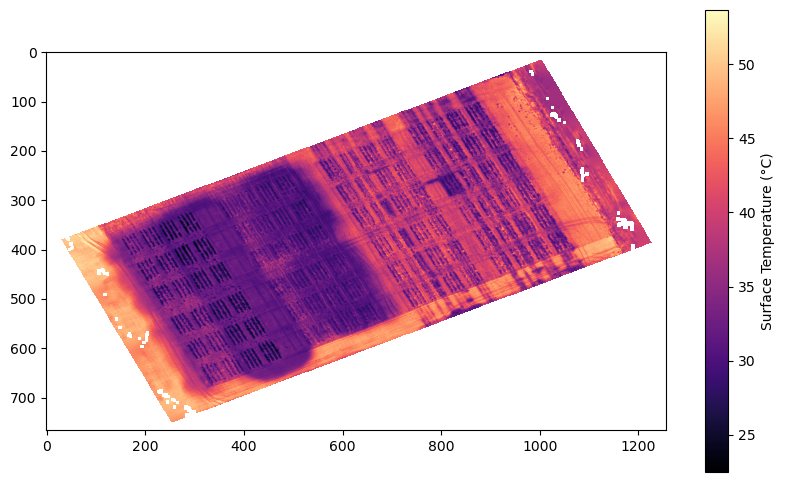

In [8]:
plt.figure(figsize=(10,6))
plt.imshow(T_surf, cmap='magma')
plt.colorbar(label='Surface Temperature (°C)')
plt.show()

## HRMET

### Vectorized Version

In [9]:
ET_v = HRMET(datetime, lon_grid, lat_grid, T_air_grid, SW_in, wind_s, 
             ea, pa, 2, 2, lai, height, T_surf, alb_soil, alb_veg, 
             emiss_soil, emiss_veg, 1)

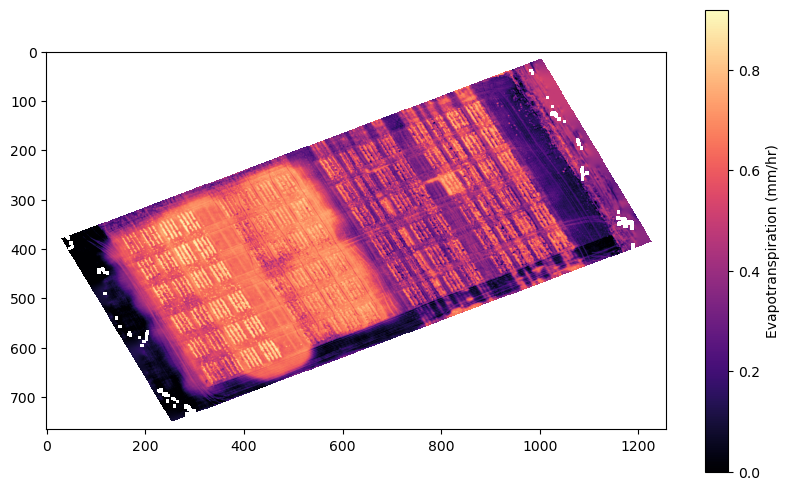

In [10]:
plt.figure(figsize=(10,6))
plt.imshow(ET_v, cmap='magma')
plt.colorbar(label='Evapotranspiration (mm/hr)')
plt.show()

### Original Author's Version

For performance and results comparison, we will also run `HRMET` using its 
original author's method, which consists in:
1. Creating an empty grid with the size of `T_surf`.
2. Iterating through each individual pixel in `T_surf` and performing `HRMET`.
3. In each iteration, we place the resulting value of `HRMET`, `ET`,
in its corresponding coordinate in the empty grid.

In [11]:
# Initialize progress bar
current_progress = 0
total_progress = T_surf[~np.isnan(T_surf)].size
start_time = time.time()

# Loop over grid points in T_surf and run HRMET
ET_map = np.full_like(lat_grid, np.nan)
for i in range(T_surf.shape[0]):
    for j in range(T_surf.shape[1]):
        # Skip if point temperature is NaN
        if np.isnan(T_surf[i, j]): continue
        ET_map[i, j] = HRMET_single(datetime, lon_grid[i, j], lat_grid[i, j], 
                                    T_air, SW_in, wind_s, ea, pa, 2, 2,
                                    lai, height, T_surf[i, j], alb_soil, alb_veg, 
                                    emiss_soil, emiss_veg, 1)
        
        # Update progress bar
        current_progress += 1
        progress_bar(current_progress, total_progress, start_time)
progress_bar(current_progress, total_progress, start_time)

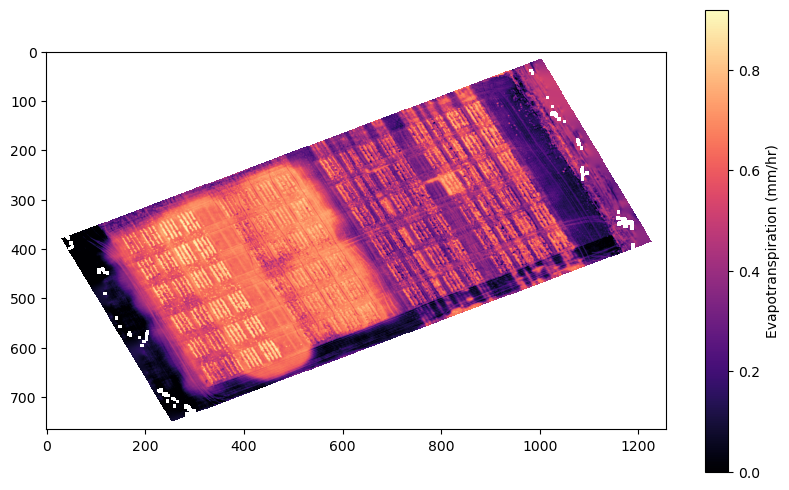

In [12]:
plt.figure(figsize=(10,6))
plt.imshow(ET_map, cmap='magma')
plt.colorbar(label='Evapotranspiration (mm/hr)')
plt.show()

### Comparison

|HRMET Method |Execution time|
|---------------|--------------|
|Original | 1m 26s |
|Vectorized | 2.3s |

There is a significant difference in the execution time of each approach.
In this example, the vectorized HRMET was ~37 times faster in execution. 
The resulting values, however, are not 100% equal to the original approach,
but the difference in between is not significant as shown below.



In [13]:
print('Mean diff in ET values: {:.7f}'.format(np.nanmean(ET_v - ET_map))) 
print('Max diff in ET values: {:.7f}'.format(np.nanmax(ET_v - ET_map)))

Mean diff in ET values: 0.0016036
Max diff in ET values: 0.0053885
